In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sklearn
import statsmodels.api as sm

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


In [2]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from cs019 lab7
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    #training_accuracy = clf.score(Xtrain, ytrain)
    #test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Make ROC Plots

from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #


### Baseline Comparison :
We first compare current years graduation rate with last years graduation rate and use that as our baseline

In [3]:
df_yr=pd.read_csv("data/finaldata/dftouse_withprevyears.csv")
print df_yr.shape
df_yr.head()

(10785, 160)


,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1,NaN,NaN,NaN
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0,100.0,100.0,100.0
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1,75.6,41.4,NaN
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1,97.1,81.6,83.3
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0,0,0.000000,0.043101,0.000000,0,0.034175,0.008926,0.004336,0.002805,0,0.004081,0.066820,0.000000,0.000000,0.004081,0,0.00000,0.859543,0.000000,0.000000,0.118656,0.000000,0.002144,0,0,0.000000,0.001072,0.018585,0.000000,0.000000,0,0.095816,0.107962,0.1

In [4]:
# Removing rows containing NaN for the model that will make use of previous years grad rate.
df_yr = df_yr[np.isfinite(df_yr['gradrate0607'])]
df_yr = df_yr[np.isfinite(df_yr['gradrate0708'])]
df_yr = df_yr[np.isfinite(df_yr['gradrate0809'])]
df_yr = df_yr[np.isfinite(df_yr['afgr'])]
df_yr.fillna(value=np.nan, inplace=True)

print df_yr.shape

(9746, 160)


Mean Squared Error : 
Prediction for 2009-10 using 2009-09 :  117.008516314
Prediction for 2008-09 using 2007-08 :  114.726349271
Prediction for 2007-08 using 2006-07 :  113.480710035


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


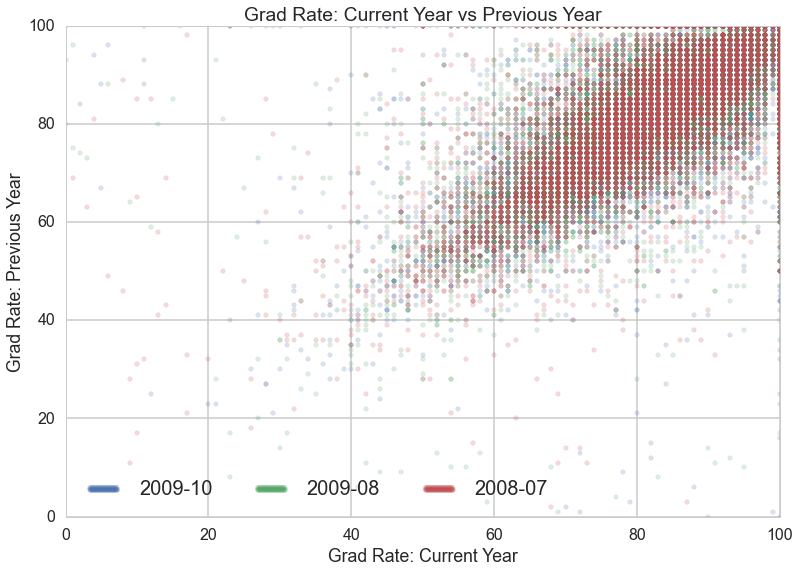

In [5]:
# Baseline Comparisons
from sklearn.metrics import mean_squared_error

y_0607 = df_yr['gradrate0607'].astype(int)
y_0708 = df_yr['gradrate0708'].astype(int)
y_0809 = df_yr['gradrate0809'].astype(int)
y_0910 = df_yr['afgr'].astype(int)

print "Mean Squared Error : "
rscore =  mean_squared_error(y_0910, y_0809)
print "Prediction for 2009-10 using 2009-09 : ", rscore

rscore =  mean_squared_error(y_0809, y_0708)
print "Prediction for 2008-09 using 2007-08 : ", rscore

rscore =  mean_squared_error(y_0708, y_0607)
print "Prediction for 2007-08 using 2006-07 : ", rscore

colors=sns.color_palette()
p1 = plt.scatter(y_0910, y_0809, alpha=0.2, color=colors[0])
p2 = plt.scatter(y_0809, y_0708, alpha=0.2, color=colors[1])
p3 = plt.scatter(y_0708, y_0607, alpha=0.2, color=colors[2])
    
plt.xlabel("Grad Rate: Current Year")
plt.ylabel("Grad Rate: Previous Year")
plt.title("Grad Rate: Current Year vs Previous Year")
plt.xlim(0,100)
plt.ylim(0,100)
plt.legend((p1, p2, p3),('2009-10', '2009-08', '2008-07'),
           scatterpoints=100,
           loc='lower left',
           ncol=3,
           fontsize=20)
plt.show()    

### Building a Predictive model using the school districts dataset and previous years graduation rates.

In [29]:
# Create test/train mask
itrain, itest = train_test_split(xrange(df_yr.shape[0]), train_size=0.7)
mask=np.ones(df_yr.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(df_yr['afgr'][mask])
print "% Graduation in Testing:", np.mean(df_yr['afgr'][~mask])


% Graduation in Training: 83.0694077983
% Graduation in Testing: 83.5308139535


** Indicators used : Funding/Expenditure/Location/School and Race/Sex and Previous Years **

In [30]:
# Indicators used : Funding/Expenditure/Location/School Types and Race/Sex
Xnames1 = [
            'pupil_teacher_ratio_dist',
            'totalrev_pp',
            'tcurinst_pp',
            'tcurssv_pp',
            'tcursalary_pp',
            'tcurbenefits_pp',
            'totalexp_pp',
            'tcapout_pp',
            'tnonelse_pp',
            'tcurelsc_pp',
            'instexp_pp',
            'i_agency_type_local_school_district',
            'i_agency_type_local_school_district_sup_union',
            'i_agency_type_regional_education_services',
            'i_agency_type_charter_school_agency',
            'i_fin_sdlc_sec',
            'i_fin_sdlc_elem_sec',
            'i_fin_sdlc_voc',
            'i_ucl_city_large',
            'i_ucl_city_mid',
            'i_ucl_city_small',
            'i_ucl_suburb_large',
            'i_ucl_suburb_mid',
            'i_ucl_suburb_small',
            'i_ucl_town_fringe',
            'i_ucl_town_distant',
            'i_ucl_town_remote',
            'i_ucl_rural_fringe',
            'i_ucl_rural_distant',
            'i_ucl_rural_remote',
            'i_cs_all_charter',
            'i_cs_charter_noncharter',
            'i_cs_all_noncharter',
            'i_ma_ne_nr',
            'i_ma_metropolitan',
            'i_ma_micropolitan',            
            'r_ELL',
            'r_IEP',
            'r_stud_re_M',
            'r_stud_re_F',
            'r_stud_re_AIAN',
            'r_stud_re_AAP',
            'r_stud_re_H',
            'r_stud_re_B',
            'r_stud_re_W',
            'r_stud_re_HNPI',
            'r_stud_re_Two',
            'gradrate0607',
            'gradrate0708',
            'gradrate0809',
            'r_lunch_free',
            'r_lunch_reduced'

]
# Adding Target column :
df_yr['target'] = df_yr['afgr'].astype(int)
target1 = 'target'


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 9, 'min_samples_leaf': 11} 0.3280671658 [mean: 0.20321, std: 0.08812, params: {'max_depth': 5, 'min_samples_leaf': 5}, mean: 0.20611, std: 0.08917, params: {'max_depth': 5, 'min_samples_leaf': 6}, mean: 0.20612, std: 0.08917, params: {'max_depth': 5, 'min_samples_leaf': 7}, mean: 0.20604, std: 0.08792, params: {'max_depth': 5, 'min_samples_leaf': 8}, mean: 0.20572, std: 0.08781, params: {'max_depth': 5, 'min_samples_leaf': 9}, mean: 0.20611, std: 0.08981, params: {'max_depth': 5, 'min_samples_leaf': 10}, mean: 0.20577, std: 0.09014, params: {'max_depth': 5, 'min_samples_leaf': 11}, mean: 0.19907, std: 0.08181, params: {'max_depth': 5, 'min_samples_leaf': 12}, mean: 0.19979, std: 0.08255, params: {'max_depth': 5, 'min_samples_leaf': 13}, mean: 0.19979, std: 0.08255, params: {'max_depth': 5, 'min_samples_leaf': 14}, mean: 0.19923, std: 0.08250, params: {'max_depth': 5, 'min_samples_leaf': 15}, mean: 0.27691, std: 0.08310, params: {'max_depth': 6, 'min_samples_leaf': 5}

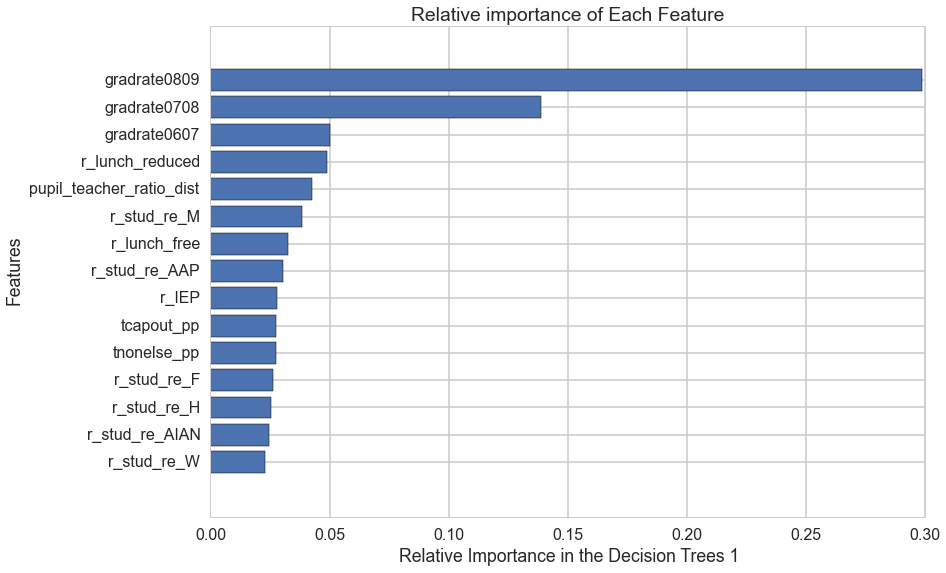

In [9]:
# Descision Trees
from sklearn import tree

clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [5, 6, 7, 9, 10, 11, 12], 'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df_yr, 
                                                     Xnames1, target1, 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'r2')

importance_list = clfTree1.feature_importances_
name_list = df_yr[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Decision Trees 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


Mean Squared Error :  123.020861833


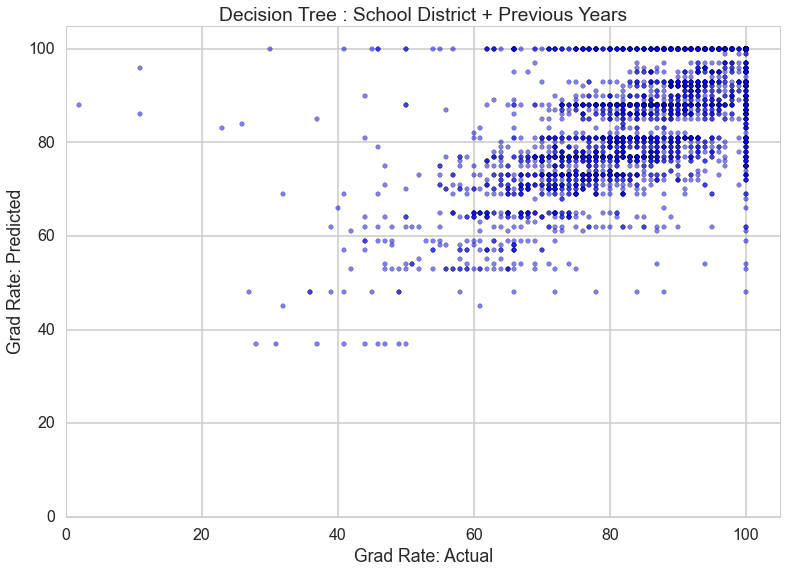

In [10]:
ypredict = clfTree1.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Decision Tree : School District + Previous Years")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 37} 0.214819587923 [mean: 0.19190, std: 0.05806, params: {'n_estimators': 25}, mean: 0.17993, std: 0.06098, params: {'n_estimators': 26}, mean: 0.19035, std: 0.04496, params: {'n_estimators': 27}, mean: 0.19499, std: 0.07268, params: {'n_estimators': 28}, mean: 0.18869, std: 0.04591, params: {'n_estimators': 29}, mean: 0.19954, std: 0.03369, params: {'n_estimators': 30}, mean: 0.19659, std: 0.05539, params: {'n_estimators': 31}, mean: 0.18981, std: 0.03082, params: {'n_estimators': 32}, mean: 0.20172, std: 0.05929, params: {'n_estimators': 33}, mean: 0.20990, std: 0.04834, params: {'n_estimators': 34}, mean: 0.21281, std: 0.02922, params: {'n_estimators': 35}, mean: 0.19330, std: 0.02666, params: {'n_estimators': 36}, mean: 0.21482, std: 0.02848, params: {'n_estimators': 37}, mean: 0.20632, std: 0.03792, params: {'n_estimators': 38}, mean: 0.19968, std: 0.05726, params: {'n_estimators': 39}]


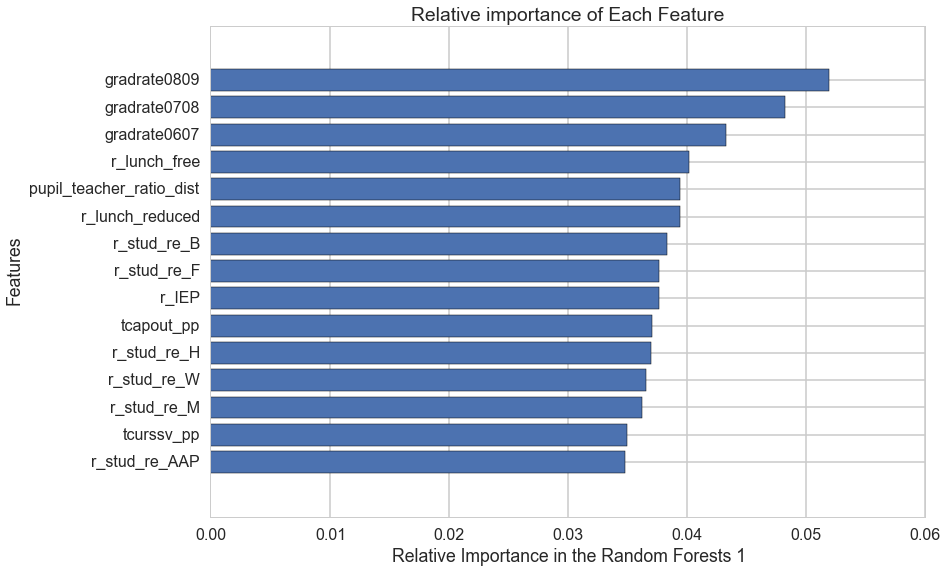

In [15]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

clfForest1 = RandomForestClassifier()

parameters = {"n_estimators": range(25, 40)}
clfForest1, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest1, parameters, 
                                                       df_yr, Xnames1, target1, 1, mask=mask, 
                                                       n_jobs = 4, score_func='r2')

importance_list = clfForest1.feature_importances_
name_list = df_yr[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forests 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

Mean Squared Error :  128.09370725


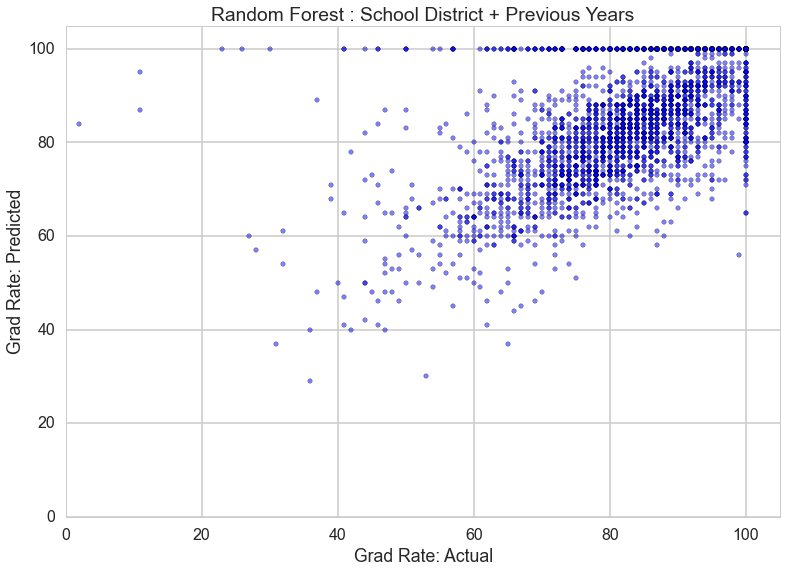

In [16]:
ypredict = clfForest1.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Random Forest : School District + Previous Years")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

### Building a model using School Districts
Here we try to build a model using only the school districts. The goal is that this model can help school asses what they could do to improve their perfomance. So focus is only on the indiciators over which schools like some control. For this reason race and gender information would not be used.

In [18]:
df=pd.read_csv("data/finaldata/dftouse.csv")
print df.shape

# Create test/train mask
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(df['afgr'][mask])
print "% Graduation in Testing:", np.mean(df['afgr'][~mask])

# Indicators used : Funding/Expenditure/Location/School Types (no Race)
Xnames2 = [
            'pupil_teacher_ratio_dist',
            'totalrev_pp',
            'tcurinst_pp',
            'tcurssv_pp',
            'tcursalary_pp',
            'tcurbenefits_pp',
            'totalexp_pp',
            'tcapout_pp',
            'tnonelse_pp',
            'tcurelsc_pp',
            'instexp_pp',
            'i_agency_type_local_school_district',
            'i_agency_type_local_school_district_sup_union',
            'i_agency_type_regional_education_services',
            'i_agency_type_charter_school_agency',
            'i_fin_sdlc_sec',
            'i_fin_sdlc_elem_sec',
            'i_fin_sdlc_voc',
            'i_ucl_city_large',
            'i_ucl_city_mid',
            'i_ucl_city_small',
            'i_ucl_suburb_large',
            'i_ucl_suburb_mid',
            'i_ucl_suburb_small',
            'i_ucl_town_fringe',
            'i_ucl_town_distant',
            'i_ucl_town_remote',
            'i_ucl_rural_fringe',
            'i_ucl_rural_distant',
            'i_ucl_rural_remote',
            'i_cs_all_charter',
            'i_cs_charter_noncharter',
            'i_cs_all_noncharter',
            'i_ma_ne_nr',
            'i_ma_metropolitan',
            'i_ma_micropolitan',            
            'r_ELL',
            'r_IEP',
            'r_lunch_free',
            'r_lunch_reduced'
]

# Target :
# Adding Target column :
df['target'] = df['afgr'].astype(int)
target2 = 'target'


(10785, 157)
% Graduation in Training: 82.6163862763
% Graduation in Testing: 82.8688504326


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 14, 'min_samples_leaf': 10} -0.218100279973 [mean: -0.26370, std: 0.09664, params: {'max_depth': 10, 'min_samples_leaf': 10}, mean: -0.29893, std: 0.09316, params: {'max_depth': 10, 'min_samples_leaf': 11}, mean: -0.29119, std: 0.06134, params: {'max_depth': 10, 'min_samples_leaf': 12}, mean: -0.26574, std: 0.05690, params: {'max_depth': 10, 'min_samples_leaf': 13}, mean: -0.27165, std: 0.05299, params: {'max_depth': 10, 'min_samples_leaf': 14}, mean: -0.26253, std: 0.05461, params: {'max_depth': 10, 'min_samples_leaf': 15}, mean: -0.27945, std: 0.06904, params: {'max_depth': 10, 'min_samples_leaf': 16}, mean: -0.29685, std: 0.07532, params: {'max_depth': 10, 'min_samples_leaf': 17}, mean: -0.30354, std: 0.07387, params: {'max_depth': 10, 'min_samples_leaf': 18}, mean: -0.28858, std: 0.07639, params: {'max_depth': 10, 'min_samples_leaf': 19}, mean: -0.29426, std: 0.04905, params: {'max_depth': 10, 'min_samples_leaf': 20}, mean: -0.23754, std: 0.10548, params: {'max_d

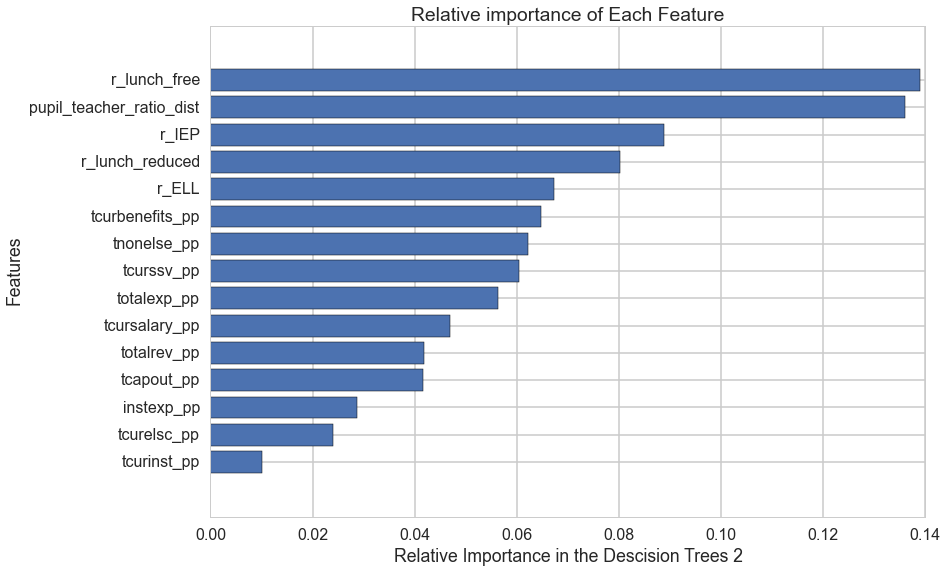

In [22]:
# Descision Tree
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [10, 11, 12, 13, 14, 15], 'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames2, target2, 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'r2')

importance_list = clfTree2.feature_importances_
name_list = df[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Descision Trees 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


Mean Squared Error :  241.988257108


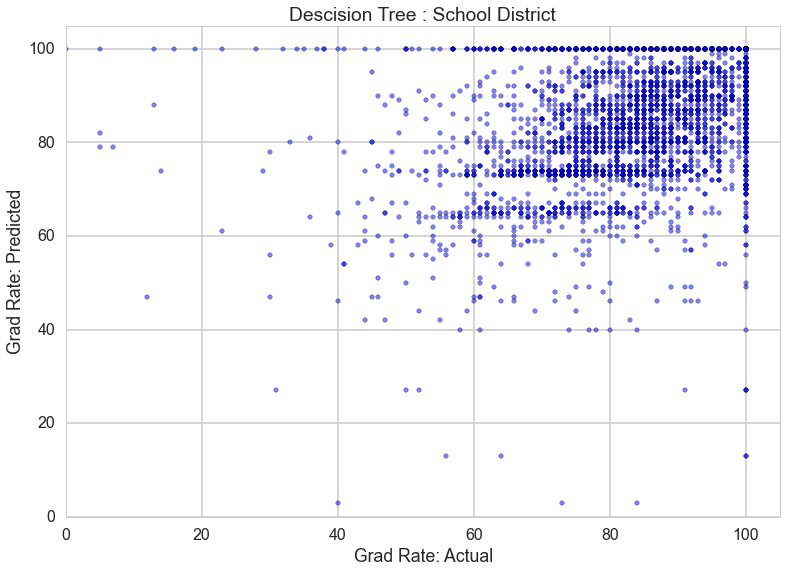

In [23]:
ypredict = clfTree2.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Descision Tree : School District ")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 17} -0.332956610936 [mean: -0.52002, std: 0.17475, params: {'n_estimators': 1}, mean: -0.61501, std: 0.19602, params: {'n_estimators': 2}, mean: -0.99410, std: 0.31688, params: {'n_estimators': 3}, mean: -1.11374, std: 0.29154, params: {'n_estimators': 4}, mean: -1.15070, std: 0.30307, params: {'n_estimators': 5}, mean: -1.09943, std: 0.22694, params: {'n_estimators': 6}, mean: -0.96205, std: 0.16754, params: {'n_estimators': 7}, mean: -0.82604, std: 0.21478, params: {'n_estimators': 8}, mean: -0.68109, std: 0.11618, params: {'n_estimators': 9}, mean: -0.59850, std: 0.10669, params: {'n_estimators': 10}, mean: -0.52486, std: 0.07727, params: {'n_estimators': 11}, mean: -0.49005, std: 0.10088, params: {'n_estimators': 12}, mean: -0.46214, std: 0.06514, params: {'n_estimators': 13}, mean: -0.39884, std: 0.08641, params: {'n_estimators': 14}, mean: -0.40325, std: 0.05198, params: {'n_estimators': 15}, mean: -0.35401, std: 0.05275, params: {'n_estimators': 16}, mean: 

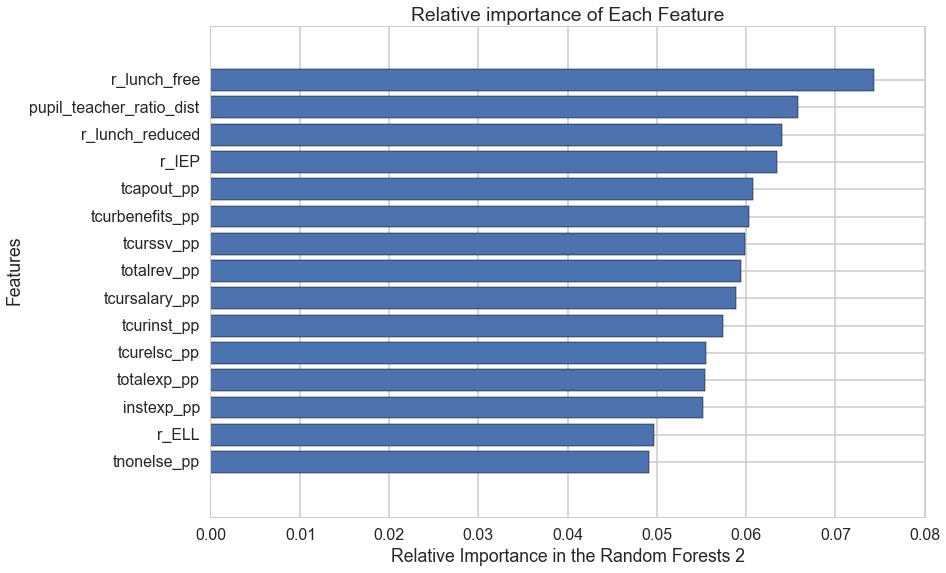

In [26]:
# Random Forests
clfForest2 = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest2, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest2, parameters, 
                                                       df, Xnames2, target2, 1, mask=mask, 
                                                       n_jobs = 4, score_func='r2')

importance_list = clfForest2.feature_importances_
name_list = df[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forests 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

Mean Squared Error :  246.654511743


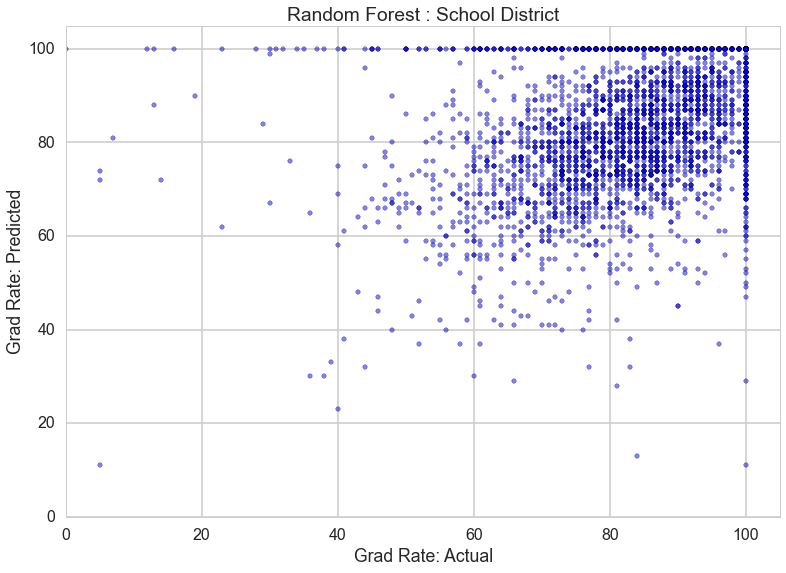

In [27]:
ypredict = clfForest2.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Random Forest : School District ")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    